In [382]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_val_predict
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import FunctionTransformer

from copy import copy
from tpot.builtins import StackingEstimator
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
from catboost import CatBoostRegressor,Pool,cv
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase
from src.data.make_dataset import DROPCOLS

## Load data

In [383]:
df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')

#df_flat = df_tsfresh.pivot(df_tsfresh)
#df_flat.columns = ['_'.join(col).strip() for col in df_flat.columns.values]


In [384]:
year = 2019
X = data_dict[year]['X_train_tsclean'].astype(float)
X_test = data_dict[year]['X_test_ts'].astype(float)

y = data_dict[year]['y_train_tsclean'].astype(float).loc[:,['rougher.output.recovery','final.output.recovery']]
mask = data_dict[year]['mask']
X = X[mask]
y = y[mask]




print(f'{X.shape}')

(13590, 388)


# Keras NNet solution

In [436]:
# bagging mlp ensemble on blobs dataset
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.datasets.samples_generator import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.regularizers import l1,l2
from keras.optimizers import Adam,SGD
from keras.initializers import random_uniform,glorot_uniform,he_uniform
from keras.layers import Dense,Dropout,BatchNormalization,Activation,ReLU,Input,Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,Callback,ReduceLROnPlateau,History
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
from keras_tqdm import TQDMNotebookCallback
import numpy as np
import tensorflow as tf
from keras.utils import plot_model
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

def tilted_loss( y, f,q = 0.55):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e),
                              axis=-1)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def my_loss(y_true,y_pred):
    #naive_forecast_error = K.mean(K.abs(y_true[1:,:] - y_true[:-1,:]))
    l = K.abs(y_true - y_pred) 
    r = K.variable([[0.25],[0.75]])
    error = K.dot(l,r)
    return error

def create_model(optimizer=Adam(lr=7e-3),
                 seed = 12, 
                 dropout=0.35,input_dim = 332):
    kernel_initializer=he_uniform(seed=seed)
    main_input = Input(shape = (input_dim,),name = 'main_input')
    d1 = Dense(768,input_dim = input_dim,kernel_initializer=kernel_initializer,kernel_regularizer=l1(4e0))(main_input)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    #d1 = Dropout(dropout/2)(d1)
    
    d2 = Dense(256,kernel_initializer=kernel_initializer,activation = None,kernel_regularizer=l1(3e0))(d1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    #d2 = Dropout(dropout)(d2)
    
  
    
    d4 = Dense(32,kernel_initializer=kernel_initializer,activation = None,kernel_regularizer=l1(2e0))(d2)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    #d4 = Dropout(dropout)(d4)
    
    output_rougher = Dense(1,activation=None,kernel_regularizer=l1(1e-3))(d4)
    output_rougher = ReLU(max_value = 100,name = 'rough')(output_rougher)
    concat_layer = Concatenate()([d4,output_rougher])
    concat_layer =Dropout(dropout)(concat_layer)
    
    output_final = Dense(1,activation = None,kernel_initializer =kernel_initializer)(concat_layer)
    output_final = ReLU(max_value=100,name = 'final')(output_final)
    
    model = Model(inputs=main_input, outputs=[output_rougher, output_final])
    
    model.compile(loss=['mae','mae'],optimizer=optimizer, metrics=['mae'],loss_weights = [0.5,0.75])
    
    return model



# wrap the model using the function you created
reg = KerasRegressor(build_fn=create_model,input_dim = X.shape[1],verbose=0)
reg = create_model(input_dim = X.shape[1])
#print(reg)
#scaler = make_pipeline(QuantileTransformer(output_distribution='normal',n_quantiles = 5000))
#scaler = make_pipeline(PCA(whiten=True))
scaler = make_pipeline(RobustScaler())
target_scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),StandardScaler())
hr = History()
#clr = CyclicLR(base_lr = 8e-4,max_lr = 5e-2,step_size=4802, mode='triangular2')
#callbacks = [EarlyStopping(monitor='val_loss', patience=40),TQDMNotebookCallback(leave_inner=False),
#             clr,hr]
# params = {"epochs":150,
#              "verbose":0,
#              "batch_size":128,
#              "callbacks":callbacks}


In [437]:
import sys
import os
reg.summary()
#plot_model(reg)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 388)          0                                            
__________________________________________________________________________________________________
dense_435 (Dense)               (None, 768)          298752      main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_252 (BatchN (None, 768)          3072        dense_435[0][0]                  
__________________________________________________________________________________________________
activation_267 (Activation)     (None, 768)          0           batch_normalization_252[0][0]    
__________________________________________________________________________________________________
dense_436 

In [438]:
# 2.08 with custom loss, bs = 128, seed = 123, random_uniform, mode = 'triangular2'
bs = 64
seed = 12
fold_n = 1
model = reg
scores = []


df_test_all =[]
#fig,ax = plt.subplots(figsize = (20,16),nrows = 1)
scaler.fit(X)


history = [None]
fpath = f'./keras-ch/multi_2target.h5'
#clr_fn = lambda x: 0.9**x # 54*10*4
#clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
#clr = CyclicLR(base_lr = 7e-3,max_lr = 1e-2,step_size=54*8*4, mode='triangular',scale_fn=clr_fn, scale_mode='cycle')
mc = ModelCheckpoint(filepath=fpath, monitor='val_final_mean_absolute_error',save_best_only=True,verbose =1)
M = 5 # number of snapshots
nb_epoch = T = 600 # number of epochs
alpha_zero = 1.5e-2 # initial learning rate
model_prefix = 'mod_ts'
snapshot = SnapshotCallbackBuilder(T, M, alpha_zero) 
cbcks = snapshot.get_callbacks(model_prefix=model_prefix,monitor_metric ="val_final_mean_absolute_error")
cbcks = cbcks + [hr,TQDMNotebookCallback()]

train_index = X.index < pd.to_datetime("2018-04-04").tz_localize('UTC')
valid_index = X.index > pd.to_datetime("2018-04-04").tz_localize('UTC')

X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


preds_all_base = np.empty_like(y_valid)
true_all =np.empty_like(y_valid)


mask_train,mask_valid = mask.iloc[train_index,],mask.iloc[valid_index,]
X_train, X_valid = scaler.transform(X_train), scaler.transform(X_valid)
# Do the base

params = {"epochs":nb_epoch,
         "verbose":0,
         "batch_size":bs,
         "callbacks":cbcks}
params["validation_data"] = (X_valid, {'rough':y_valid.values[:,0],'final':y_valid.values[:,1]})
model = create_model(input_dim = X_train.shape[1])

history[0] = model.fit(X_train,{'rough':y_train.values[:,0],'final':y_train.values[:,1]},**params)



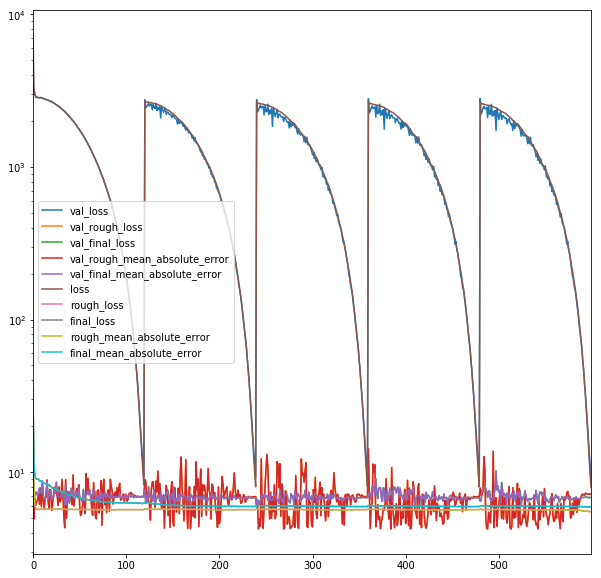

In [439]:
pd.DataFrame(history[0].history).drop('lr',axis = 1).plot(figsize = (10,10),logy=True)

In [440]:
def calculate_weighted_pred(x,prediction_weights):
    weighted_predictions = np.zeros((x[0].shape[0], 2), dtype='float32')
    for weight, prediction in zip(prediction_weights, x):
        weighted_predictions += weight * prediction
    yPred = weighted_predictions
    return weighted_predictions
# Define a helper function for calculating the average of snapshots:

preds = []
preds_test = []
model = create_model(input_dim = X_train.shape[1])
model_filenames = [f'./weights/mod_ts-{i+1}.h5' for i in range(5)]
model_filenames.append('./weights/mod_ts-Best.h5')

for fn in model_filenames:
    model.load_weights(fn)
    yTrue = y_valid.values
    yPred = np.hstack(model.predict(X_valid, batch_size=64))
    X_test_sc = scaler.transform(X_test)
    yPredTest = np.hstack(model.predict(X_test_sc, batch_size=64))
    mase_sc = 0.25 * mase(yPred[:,0],yTrue[:,0]) + 0.75 * mase(yPred[:,1],yTrue[:,1])
    print(f'MASE: {mase_sc}')
    preds.append(yPred)
    preds_test.append(yPredTest)
    print("Obtained predictions from model with weights = %s" % (fn))


MASE: 2.4037905642535646
Obtained predictions from model with weights = ./weights/mod_ts-1.h5
MASE: 2.3814150162724808
Obtained predictions from model with weights = ./weights/mod_ts-2.h5
MASE: 2.3827605531398
Obtained predictions from model with weights = ./weights/mod_ts-3.h5
MASE: 2.3808490934049784
Obtained predictions from model with weights = ./weights/mod_ts-4.h5
MASE: 2.4286614089396577
Obtained predictions from model with weights = ./weights/mod_ts-5.h5
MASE: 1.8161119220491195
Obtained predictions from model with weights = ./weights/mod_ts-Best.h5


### optimize weights

In [441]:
from scipy.optimize import minimize
def loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((X_valid.shape[0], 2), dtype='float32')

    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction

    return 0.25 * mase(final_prediction[:,0],yTrue[:,0]) + 0.75 * mase(final_prediction[:,1],yTrue[:,1])

best_mase = 100.0
best_weights = None

# Parameters for optimization
constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
bounds = [(0, 1)] * len(preds)
NUM_TESTS = 50
# Check for NUM_TESTS times
for iteration in range(NUM_TESTS):
    # Random initialization of weights
    prediction_weights = np.random.random(len(model_filenames))
    
    # Minimise the loss 
    result = minimize(loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
    
    weights = result['x']
    weighted_predictions = np.zeros((X_valid.shape[0], 2), dtype='float32')
    
    # Calculate weighted predictions
    for weight, prediction in zip(weights, preds):
        weighted_predictions += weight * prediction

    yPred = weighted_predictions
    yTrue = y_valid.values
    sc = 0.25 * mase(yPred[:,0],yTrue[:,0]) + 0.75 * mase(yPred[:,1],yTrue[:,1])
    print(sc)
    
    # Save current best weights 
    if sc > best_mase:
        best_acc = sc
        best_weights = weights
        
    print()
# 0.00000000e+00 1.53911667e-15 4.63643997e-02 0.00000000e+00
# 7.57377707e-02 8.77897830e-01]

Best Ensemble Weights: [5.43150548e-02 7.87198232e-05 2.35237047e-01 0.00000000e+00
 3.43726945e-01 3.66642234e-01]
2.0987990521119855

Best Ensemble Weights: [2.61114694e-01 5.23895690e-01 2.14989614e-01 3.53031707e-10
 3.44846095e-10 0.00000000e+00]
2.3874353038945926

Best Ensemble Weights: [1.14270518e-13 2.36211702e-01 1.10605969e-14 2.93061303e-01
 1.29420786e-13 4.70726995e-01]
2.0175190006619808

Best Ensemble Weights: [5.24106425e-02 1.73276962e-01 5.97554904e-02 1.11638108e-01
 1.82920176e-18 6.02918797e-01]
1.9448096361479812

Best Ensemble Weights: [3.95785889e-01 2.81633603e-15 4.02389414e-02 1.56165472e-01
 2.03354633e-01 2.04455064e-01]
2.2235356106560715

Best Ensemble Weights: [0.50288494 0.         0.18084374 0.07101299 0.         0.24525833]
2.18499718738893

Best Ensemble Weights: [3.80798374e-01 4.89498056e-04 2.81997981e-05 2.78761558e-01
 8.78838549e-13 3.39922376e-01]
2.1108876471642706

Best Ensemble Weights: [2.55972953e-11 2.76833158e-11 1.24157556e-01 2.0362

In [442]:
w = np.array([1,1,1,1,1,1])
w = w / np.sum(w)
preds_test_w  = calculate_weighted_pred(preds_test,w)
df_test = pd.DataFrame({"preds_r":preds_test_w[:,0].reshape(-1,),"preds_f":preds_test_w[:,1].reshape(-1,),'date':X_test.index})


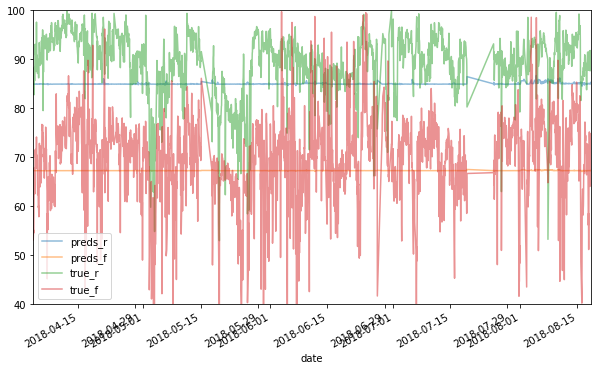

In [443]:
preds_all_base  = calculate_weighted_pred(preds,w)
df = pd.DataFrame({"preds_r":preds_all_base[:,0],"preds_f":preds_all_base[:,1],"true_r":y_valid.values[:,0],"true_f":y_valid.values[:,1]},index = y_valid.index)
df.plot(figsize  =(10,6),ylim = (40,100),alpha=0.5)


In [429]:
#df_oof.columns = ['rougher.output.recovery','final.output.recovery']
#df_oof.to_pickle('./keras-ch/2-17-keras-2l-96-16-6-train.pkl')
df_test.to_pickle('./keras-ch/2-17-keras-2l-96-16-6-test.pkl')


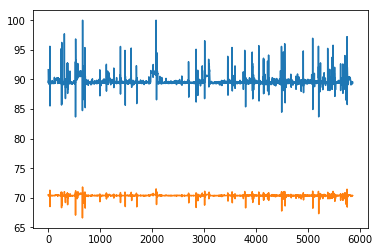

In [444]:
#df_test[['preds_r','preds_f']].plot(figsize  =(20,10),ylim = (40,100),style = ['o','o'],alpha=0.9)
#df_test[['preds_r','preds_f']].plot()
#df_test.plot(figsize  =(20,7))
#df_test\
plt.plot(preds_test[5])

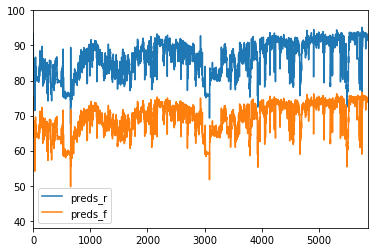

In [433]:
#df_test[['preds_r','preds_f']].plot(figsize  =(20,10),ylim = (40,100),style = ['o','o'],alpha=0.9)
df_test[['preds_r','preds_f']].plot(ylim = (38,100))
#df_test.plot(figsize  =(20,7))
#df_test

In [434]:
df_keras_su = df_test[["preds_r","preds_f","date"]].rename(index=str,columns = {"preds_r":"rougher.output.recovery","preds_f":"final.output.recovery"})
df_keras_su['date'] = df_keras_su['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
df_keras_su.set_index('date')
df_keras_su.to_csv('../results/keras_best.csv')

In [ ]:
i=0
a =history[i]
hdf = pd.DataFrame(a.history)
hdf.plot(figsize = (10,10),logy=True)

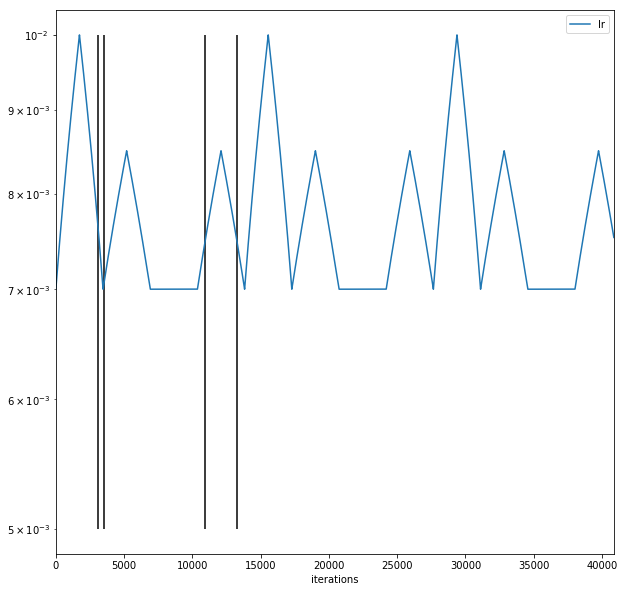

In [278]:
clr_df = pd.DataFrame(clr.history)
fig,ax = plt.subplots(figsize  =(10,10))
clr_df.plot(x='iterations',y='lr',logy=True,ax=ax)
ax.vlines(x = np.array([21,24,75,91])*146,ymin=5e-3,ymax = 1e-2)
#clr_df.groupby('batch').count()

In [219]:
95*146

13870

Epoch 1/1
9391/9391 [==============================] - ETA: 2:11 - loss: 53059.1133 - rough_loss: 81.7565 - final_loss: 63.4971 - rough_mean_absolute_error: 81.7565 - final_mean_absolute_error: 63.497 - ETA: 34s - loss: 51095.5752 - rough_loss: 81.5026 - final_loss: 62.7144 - rough_mean_absolute_error: 81.5026 - final_mean_absolute_error: 62.714 - ETA: 20s - loss: 45541.1256 - rough_loss: 82.0112 - final_loss: 63.6217 - rough_mean_absolute_error: 82.0112 - final_mean_absolute_error: 63.62 - ETA: 13s - loss: 36020.3442 - rough_loss: 81.9326 - final_loss: 63.3441 - rough_mean_absolute_error: 81.9326 - final_mean_absolute_error: 63.34 - ETA: 10s - loss: 32194.9212 - rough_loss: 81.8369 - final_loss: 63.2270 - rough_mean_absolute_error: 81.8369 - final_mean_absolute_error: 63.22 - ETA: 9s - loss: 30642.3313 - rough_loss: 81.8344 - final_loss: 63.1721 - rough_mean_absolute_error: 81.8344 - final_mean_absolute_error: 63.1721 - ETA: 8s - loss: 28713.0805 - rough_loss: 81.6034 - final_loss: 62

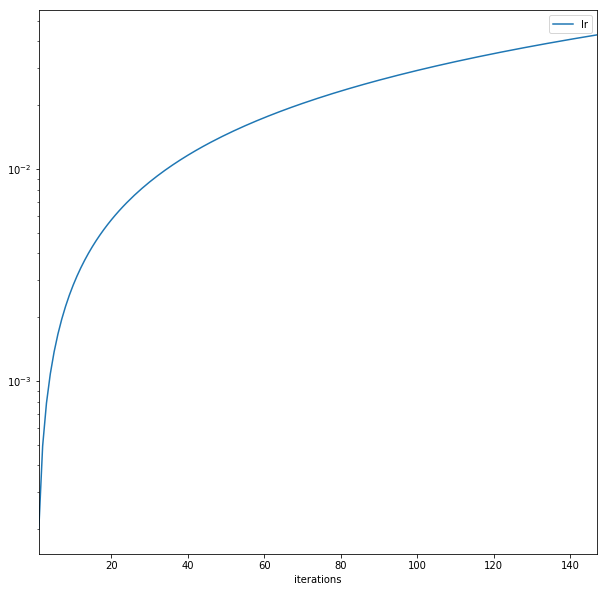

In [168]:
model = create_model(input_dim = X.shape[1])
clr = CyclicLR(base_lr = 2e-4,max_lr = 5e-2,step_size=170, mode='triangular')
# Ensure that number of epochs = 1 when calling fit()
#model.fit(X, y, epochs=1, batch_size=32, callbacks=[clr])
model.fit(X_train,{'rough':y_train.values[:,0],'final':y_train.values[:,1]}, epochs=1, batch_size=64,callbacks = [clr])
#lr_callback.plot_schedule()
clr_df = pd.DataFrame(clr.history)
clr_df.plot(x='iterations',y='lr',logy=True,figsize  =(10,10))

C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\altair\utils\core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


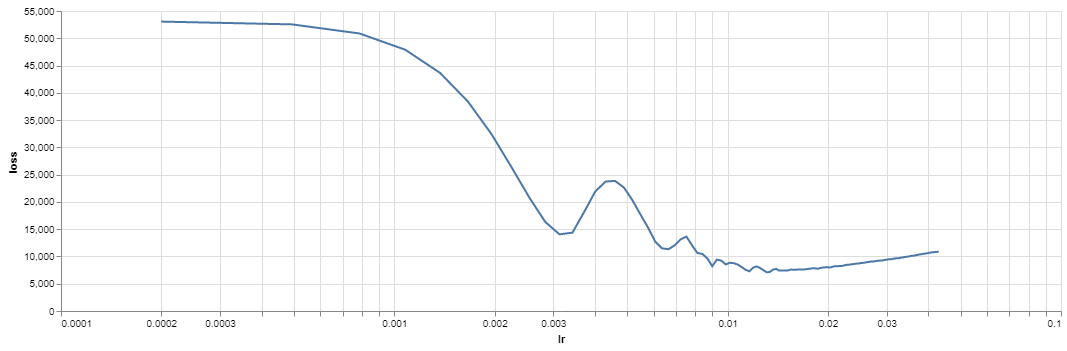

In [169]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(data=clr_df,width=1000).mark_line().encode(
x=alt.X('lr',  scale=alt.Scale(type='log')),
y='loss')
#clr_df.plot(x='lr',y='loss',figsize =(10,10),logx=True)
# 7e-3  1.5e-2

In [26]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
def create_model(optimizer=Adam(lr=7e-3),
                 seed = 12, 
                 dropout=0.5,input_dim = 332):
    kernel_initializer=random_uniform(seed=seed)
    model = Sequential()
    model.add(Dense(512,input_dim = input_dim,kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(64,kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(32,kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(16,kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    
    
    model.add(Dense(2,kernel_initializer=kernel_initializer))

    model.compile(loss='mae',optimizer=optimizer, metrics=['mae'])

    return model


In [306]:
import numpy as np
import os

import keras.callbacks as callbacks
from keras.callbacks import Callback

class SnapshotModelCheckpoint(Callback):
    """Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
        fn_prefix: prefix for the filename of the weights.
    """

    def __init__(self, nb_epochs, nb_snapshots, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots
        self.fn_prefix = fn_prefix

    def on_epoch_end(self, epoch, logs={}):
        if epoch != 0 and (epoch + 1) % self.check == 0:
            filepath = self.fn_prefix + "-%d.h5" % ((epoch + 1) // self.check)
            self.model.save_weights(filepath, overwrite=True)
            #print("Saved snapshot at weights/%s_%d.h5" % (self.fn_prefix, epoch))


class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model',monitor_metric = None):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        if not os.path.exists('weights/'):
            os.makedirs('weights/')

        callback_list = [callbacks.ModelCheckpoint("weights/%s-Best.h5" % model_prefix, monitor=monitor_metric,
                                                    save_best_only=True, save_weights_only=True),
                         callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='weights/%s' % model_prefix)]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)